<a href="https://colab.research.google.com/github/Ashu156/Image-Processing/blob/master/cFos-quantification/cFos_segmentation_deepflash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastcore opencv-python-headless==4.5.4.60
!pip install git+https://github.com/MouseLand/cellpose.git@316927eff7ad2201391957909a2114c68baee309

In [ ]:
# Imports
import numpy as np
import tifffile
import imageio
import cv2
import os
from sklearn.model_selection import KFold
from pathlib import Path
from cellpose import models, dynamics
from fastcore.foundation import L
from skimage.color import label2rgb
import matplotlib.pyplot as plt

In [ ]:
# Connect to drive
try:
  from google.colab import drive
  drive.mount('/gdrive')
except:
  print('Google Drive is not available.')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
DATASET = 'cFOS_in_HC'
SEED = 0 # We used seeds [0,1,2] in our experiemnts
OUTPUT_PATH = Path("/content/predictions") # Save predictions here
MODEL_PATH = Path("/content/models") # Save models here
PREPROC_PATH = Path("/content/data")
DATA_PATH = Path('/gdrive/MyDrive/deepflash2-paper/data')
TRAINED_MODEL_PATH= Path('/gdrive/MyDrive/benchmark_models/cellpose/')
path = DATA_PATH/DATASET

pretrained_dict = {
    'PV_in_HC':'cyto', 
    'cFOS_in_HC':'cyto2',
    'mScarlet_in_PAG':'cyto2',
    'YFP_in_CTX':'cyto',
    'GFAP_in_HC':'cyto2'
}

diam_dict = {
    'PV_in_HC':24, 
    'cFOS_in_HC':15, 
    'mScarlet_in_PAG':55, 
    'YFP_in_CTX':50,
    'GFAP_in_HC':17
}

mean_diam_dict = {
    'PV_in_HC':30, 
    'cFOS_in_HC':17, 
    'mScarlet_in_PAG':17,
    'YFP_in_CTX':30,
    'GFAP_in_HC':17,
}

# cellpose settings
channels=[0,0]
use_GPU = True
device = models.assign_device(True, use_GPU)

2022-08-09 06:46:52,520 [INFO] ** TORCH CUDA version installed and working. **
2022-08-09 06:46:52,521 [INFO] >>>> using GPU


In [ ]:
train_image_path = path/'train'/'images'
train_masks_path = path/'train'/'masks_STAPLE'

train_preproc_path = PREPROC_PATH/DATASET/f'train'
train_preproc_path.mkdir(exist_ok=True, parents=True)

train_images = [x for x in train_image_path.iterdir() if not x.name.startswith('.')]
label_fn = lambda x: train_masks_path/f'{x.name[:-4]}_mask.png'

for f in train_images:

    # images
    img = imageio.imread(f)
    shape_orig = img.shape
    min_shape = min(img.shape)
    img = img[:min_shape,:min_shape]
    print(f, shape_orig, img.shape)
    tifffile.imwrite(train_preproc_path/f'{f.stem}_img.tif', img, compress=6)

    # masks
    msk = imageio.imread(label_fn(f))
    # These labels can be noisy due to the ground truth estimation procedure (STAPLE)
    _, label_msk = cv2.connectedComponents(msk.astype('uint8'), connectivity=4)
    tifffile.imwrite(train_preproc_path/f'{f.stem}_masks.tif', label_msk, compress=6)

In [ ]:
test_image_path = path/'test'/'images'
test_files = [x for x in test_image_path.iterdir() if not x.name.startswith('.')]
test_images = list(tifffile.imread(test_files))
    
for model_type in ['cellpose_ensemble', 'cellpose_single', 'cellpose']:

    if model_type=='cellpose':
        print(model_type)
        model_type2=pretrained_dict[DATASET]
        model = models.Cellpose(gpu=use_GPU, model_type=model_type2)

        masks, flows, styles, diams = model.eval(test_images, 
                                          diameter=diam_dict[DATASET], 
                                          channels=channels
                                        )

    else:
        print('Using fine tuned model')
        pretrained_models = [x.as_posix() for x in (TRAINED_MODEL_PATH/f'{SEED+1}'/DATASET/'models').iterdir() 
                             if not x.name.endswith('_size.npy') and not x.name.startswith('.')]
        if model_type=='cellpose_single': pretrained_models = pretrained_models[:1]
        print(pretrained_models)
        model = models.CellposeModel(gpu=use_GPU, 
                                     pretrained_model=pretrained_models,
                                     diam_mean=mean_diam_dict[DATASET], 
                                    )
        
        masks, flows, styles = model.eval(test_images, 
                                          diameter=diam_dict[DATASET], 
                                          channels=channels
                                        )


    
    prediction_path = OUTPUT_PATH/DATASET/model_type
    for i, f in enumerate(test_files):
        print(f.name)
        idx = f.stem
        label_msk = masks[i]
        # Save semantic segmentation prediction
        masks_path = prediction_path/'masks'
        masks_path.mkdir(parents=True, exist_ok=True)
        imageio.imwrite(masks_path/f'{idx}.png', ((label_msk>0)*255).astype('uint8'))

        # Save instance segmentation prediction
        instance_masks_path = prediction_path/'instance_masks'
        instance_masks_path.mkdir(exist_ok=True)
        tifffile.imwrite(instance_masks_path/f'{idx}.tif', label_msk.astype('int16'), compress=6)

        # Plot
        fig, axs = plt.subplots(ncols=2, figsize=(10,5))
        axs[0].imshow(label_msk>0)
        axs[0].set_title(f'Semantic segmentation {idx}')
        axs[1].imshow(label2rgb(label_msk, bg_label=0))
        axs[1].set_title(f'Instance segmentation {idx}')
        plt.show()

In [ ]:
from skimage import io
image = io.imread('/gdrive/MyDrive/deepflash2-paper/data/cFOS_in_HC/test/images/MAX_C2-SV7 TM BLA 20X BA 2-2.tif')

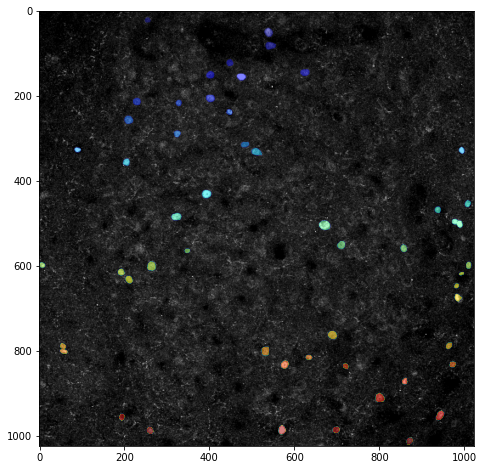

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(image, cmap = 'gray')
# plt.imshow('/content/predictions/cFOS_in_HC/cellpose/masks/MAX_C2-SV7 TM BLA 20X BLA 2-2.png')
plt.imshow(masks[9], cmap = 'jet', alpha=0.5*(masks[9]>0))

1

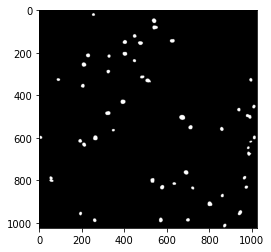

In [ ]:
ashu = masks[9]
ashu[ashu>0] = 1

plt.imshow(ashu, cmap = 'gray')
np.max(ashu)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:455: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:460: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:488: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


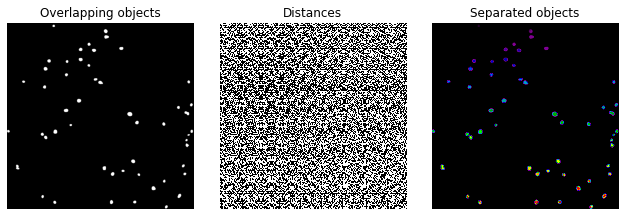

In [ ]:
distance = ndi.distance_transform_edt(masks[9])
coords = peak_local_max(distance, footprint=np.ones((30, 30)), labels = masks[9])
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask = masks[9])

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ashu, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

How many Blobs detected?: 56


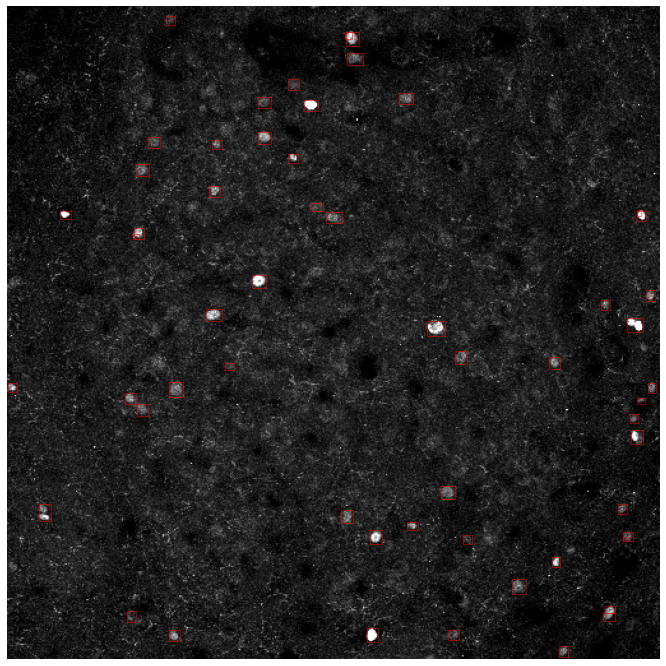

In [ ]:
from skimage.measure import label, regionprops
from skimage.segmentation import watershed
import matplotlib.patches as mpatches

# ashu_watershed = watershed(ashu, markers = ashu, connectivity = 1)
# plt.imshow(ashu_watershed)
sample_l = label(labels)
sample_rp = regionprops(sample_l)
print('How many Blobs detected?:', len(sample_rp))


fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image, cmap = 'gray')

for region in regionprops(sample_l):
    # take regions with large enough areas
    # if region.area >= 100:
        # draw rectangle around segmented coins
      minr, minc, maxr, maxc = region.bbox
      rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=0.5)
      ax.add_patch(rect)

ax.set_axis_off()

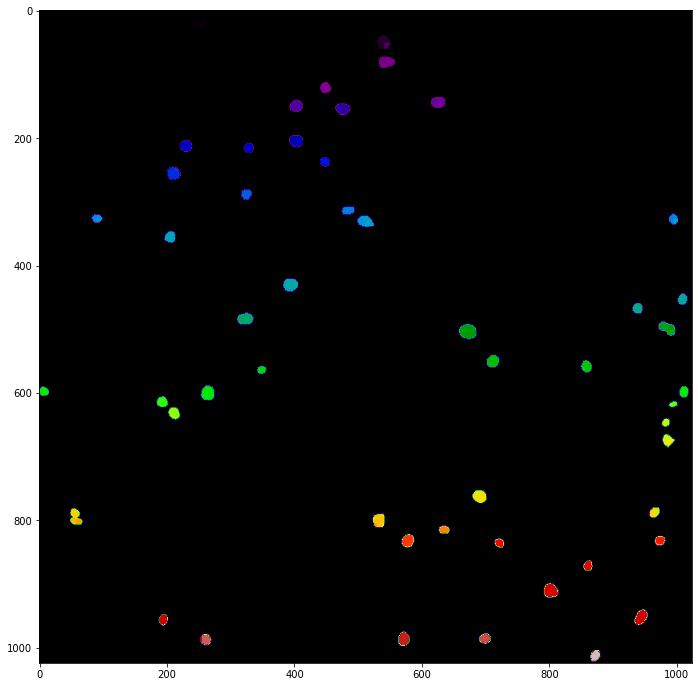

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.imshow(labels, cmap = plt.cm.nipy_spectral)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


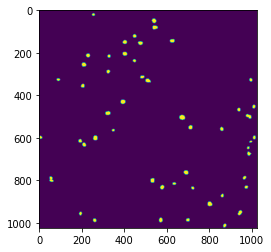

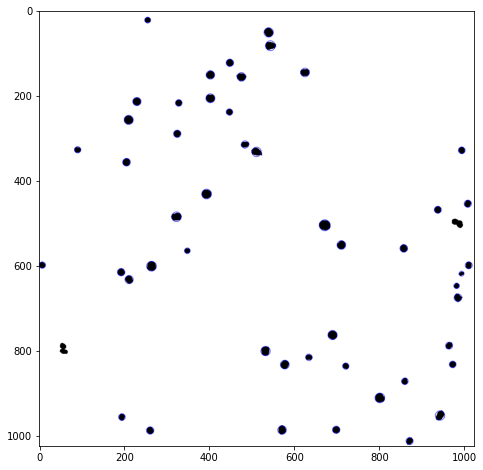

In [ ]:
!pip install opencv-contrib-python
from google.colab.patches import cv2_imshow

# Applying threshold
threshold = cv2.threshold(ashu, 0, 255,
cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(ashu)

from skimage import io, exposure, img_as_ubyte
# Convert image to uint8 format from float64
img_8bit = img_as_ubyte(exposure.rescale_intensity(threshold))

params = cv2.SimpleBlobDetector_Params()

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(img_8bit)

blank = np.zeros((1, 1))
blobs = cv2.drawKeypoints(img_8bit, keypoints, blank, (0, 0, 255),cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# cv2_imshow(blobs)
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(img_8bit, cmap = 'gray')
plt.imshow(blobs, cmap = 'jet')


In [ ]:
len(keypoints)

49

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [ ]:
# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)
image

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:455: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:460: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:488: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


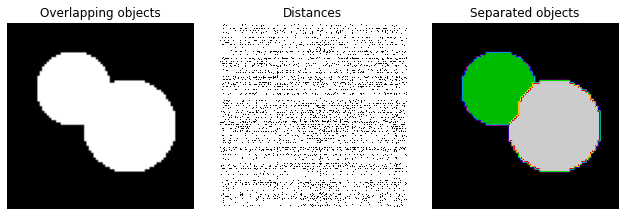

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()